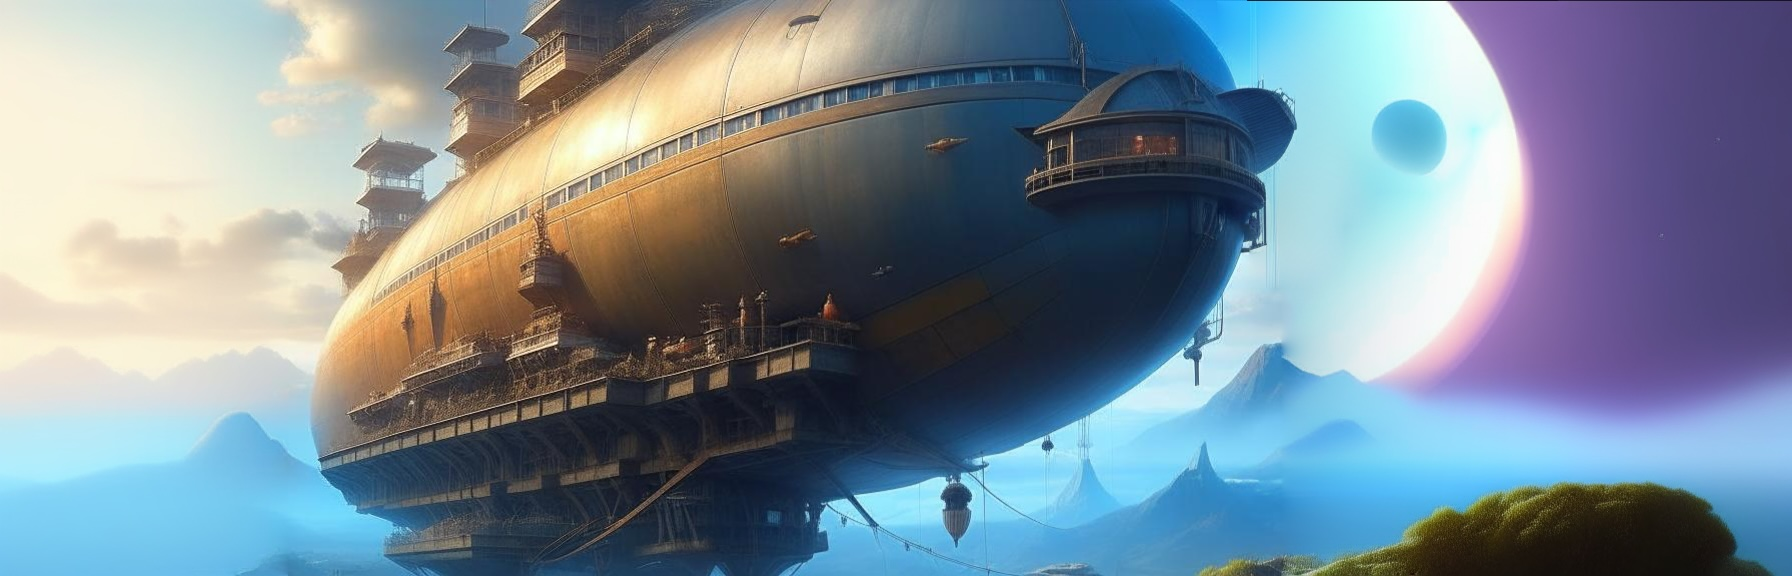
> изображение создано с помощью нейросети Кандинский / this image is genarated by Kandinsky model, (https://fusionbrain.ai/)

Это соревнование, как и его старший брат "Титаник", является учебной модельной задачей для отработки data science навыков. Во избежание повторения материала, читатель может обратиться к 1 части https://www.kaggle.com/code/adavydenko/titanic-solution-a-beginner-s-guide-russian. В данном ноутбуке мы попытаемся решить данную задачу путем разбора и создания новых признаков и обучения базовых моделей на них. На этом будет сделан акцент.

План работы:
1. Сначала рассмотрим имеющиеся столбцы и проанализируем их эффективность "как есть"
1. Обработаем данные, заполним пропуски. (#todo)
1. Выделим базовые признаки из имеющегося набора (#todo)
1. Создадим новые признаки и проанализируем их эффективность (#todo)
1. Создадим модель и подготовим данные для отправки (#todo)

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

In [59]:
df = pd.read_csv('train.csv')

In [60]:
# 2. Создание новых фичей
df['HasCabin'] = df['Cabin'].notnull().astype(int)
df['Group'] = df['PassengerId'].str.split('_').str[0]
df['TotalSpent'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
df['IsAlone'] = (df['Group'].map(df['Group'].value_counts()) == 1).astype(int)
df['Missing'] = df.isnull().sum(axis=1)

In [61]:
# --- Предобработка пропусков ---
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age', 'TotalSpent', 'Missing']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())
for col in ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'Group']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

/var/folders/gz/8kbvnrzd7mgchwyzblydqst00000gn/T/ipykernel_5596/4102394067.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [62]:

# Кодировка категориальных признаков
for col in ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'Group']:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

In [63]:
# Целевая переменная
if df['Transported'].dtype == 'bool' or df['Transported'].dtype == 'object':
    df['Transported'] = df['Transported'].map({True: 1, False: 0, 'True': 1, 'False': 0})

In [64]:
# Признаки для обучения
features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
            'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
            'HasCabin', 'Group', 'TotalSpent', 'IsAlone', 'Missing']
X = df[features]
y = df['Transported']

In [65]:
assert not X.isnull().any().any(), 'NaN'

In [66]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Сравнение моделей

In [67]:
# PCA
pca = PCA(n_components=min(5, X_train.shape[1]))
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pred_pca = DecisionTreeClassifier(random_state=42).fit(X_train_pca, y_train).predict(X_test_pca)

print(f'accuracy_score = {accuracy_score(y_test, y_pred_pca):.3f}')

accuracy_score = 0.702


/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWa

In [68]:
# Логистическая регрессия
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f'accuracy_score = {accuracy_score(y_test, y_pred_lr):.3f}')

/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/U

accuracy_score = 0.763


/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [69]:
# CatBoost
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)
print(f'accuracy_score = {accuracy_score(y_test, y_pred_cat):.3f}')

accuracy_score = 0.796


In [70]:
# Дерево решений
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'accuracy_score = {accuracy_score(y_test, y_pred_tree):.3f}')

accuracy_score = 0.727


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

from sklearn.utils.extmath import softmax

# Признаки "как есть"

Для начала обратимся к постановке задачи. По условию задачи имеем следующий набор столбцов:
* `PassengerId` - Уникальный идентификатор пассажира. *Id* имеет вид *gggg_pp*, где *gggg* обозначает группу с которой путешествует пассажир, а *pp* номер пассажира в группе. Чаще всего люди одной группы родственники, но не всегда.
* `HomePlanet` - Планета, с которой отбыл данным пассажир. Чаще всего является планетой его постоянно проживания.
* `CryoSleep` - Указывает, решил ли пассажир ввести режим анабиоза на время рейса. Пассажиры, находящиеся в криосне, находятся в своих каютах.
* `Cabin` - Номер каюты в которой остановился пассажир. Имеет вид `палуба/номер/сторона` (deck/num/side), где *сторона* может принимать 2 значения: P -- Левый борт или S -- Правый борт.
* `Destination` - Планета назначения, на которой пассажир высадится.
* `Age` - Возраст пассажира.
* `VIP` - Признак, оплатил ли пассажир специальное VIP обслуживание на время путешествия.
* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Суммы оплаченные пассажиром за каждый из видов люксовых удобств, доступных на Spaceship Titanic.
* `Name` - Имя и фамилия пассажира
* `Transported` (**label**) - Был ли пассажир перенесен в другое измерение. Это целевой столбец, который мы должны предсказать.


Внимательный читатель может подметить несколько интересных моментов, не погружаясь ни в какой Data Science, а просто внимательно прочитав условия задания.


Во-первых `PassengerId` -- составной признак, он включает информацию о группу в которой путешествует пассажир, и номер пассажира в группе. Остюда мы можем узнать размер группы. `CryoSleep` информирует о том, что пассажир никуда по кораблю не ходит, т.к. погружен в криосон в рамках своей каюты. `Cabin` также кодирует расположение каюты на корабле, а вдруг вспышка и перенос измерения был где-то сбоку, и пассажиры той части подвержены переносу? Надо будет выяснить. Все что связано с ценами может натолкнуть нас на мысль, что если пассажир тратит деньги на разного рода развлечения, возможно он привязан к этм локациям? В отличии от базового Титаника, `Name` явно содержит только *имя* и *фамилию* пассажира, суммирая эту информацию с *gggg* мы можем сделать предположение о семейных и родственных связях, вдруг инопланетяне похищали только родственников или наоборт - по одному представителю фамилии?

In [72]:
# начинаем анализ со стандартной операции – загрузкой датасета, его визуализации и анализа атрибутов

df = pd.read_csv('train.csv')
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Видно, что несмотря на то, что атрибуты `CryoSleep` и `VIP` содержат значения *True*/*False* – они не являются булевыми значениям, см. object в столбце Dtype результатов вывода `df.info()`, *object* означает "строковый" тип. Это нужно будет поправить при первичной обработке данных.

Также, можем заметить, что `CryoSleep == True` означает, что не было других трат на корабле (пассажиры *0006_02* и *0008_01* не имеют трат), в тоже самое время, мы видим записи когда пассажир не находится в Криосне, но при этом и не тратит деньги на услуги (*0001_01*).

Можем провести попарное сравнение всех признаков с цветовым разделением по `Transported`. Правда нельзя сказать, что это дает видимый эффект. Основное на что мы обращаем внимание – цветовое разделение признаков.
> * `dropna = True` просто удалеяет пустые значения (мы их еще не обрабатывали)
> * `corner = True` используем исключительно для большей производительности, да и зеркальные значения можно опустить


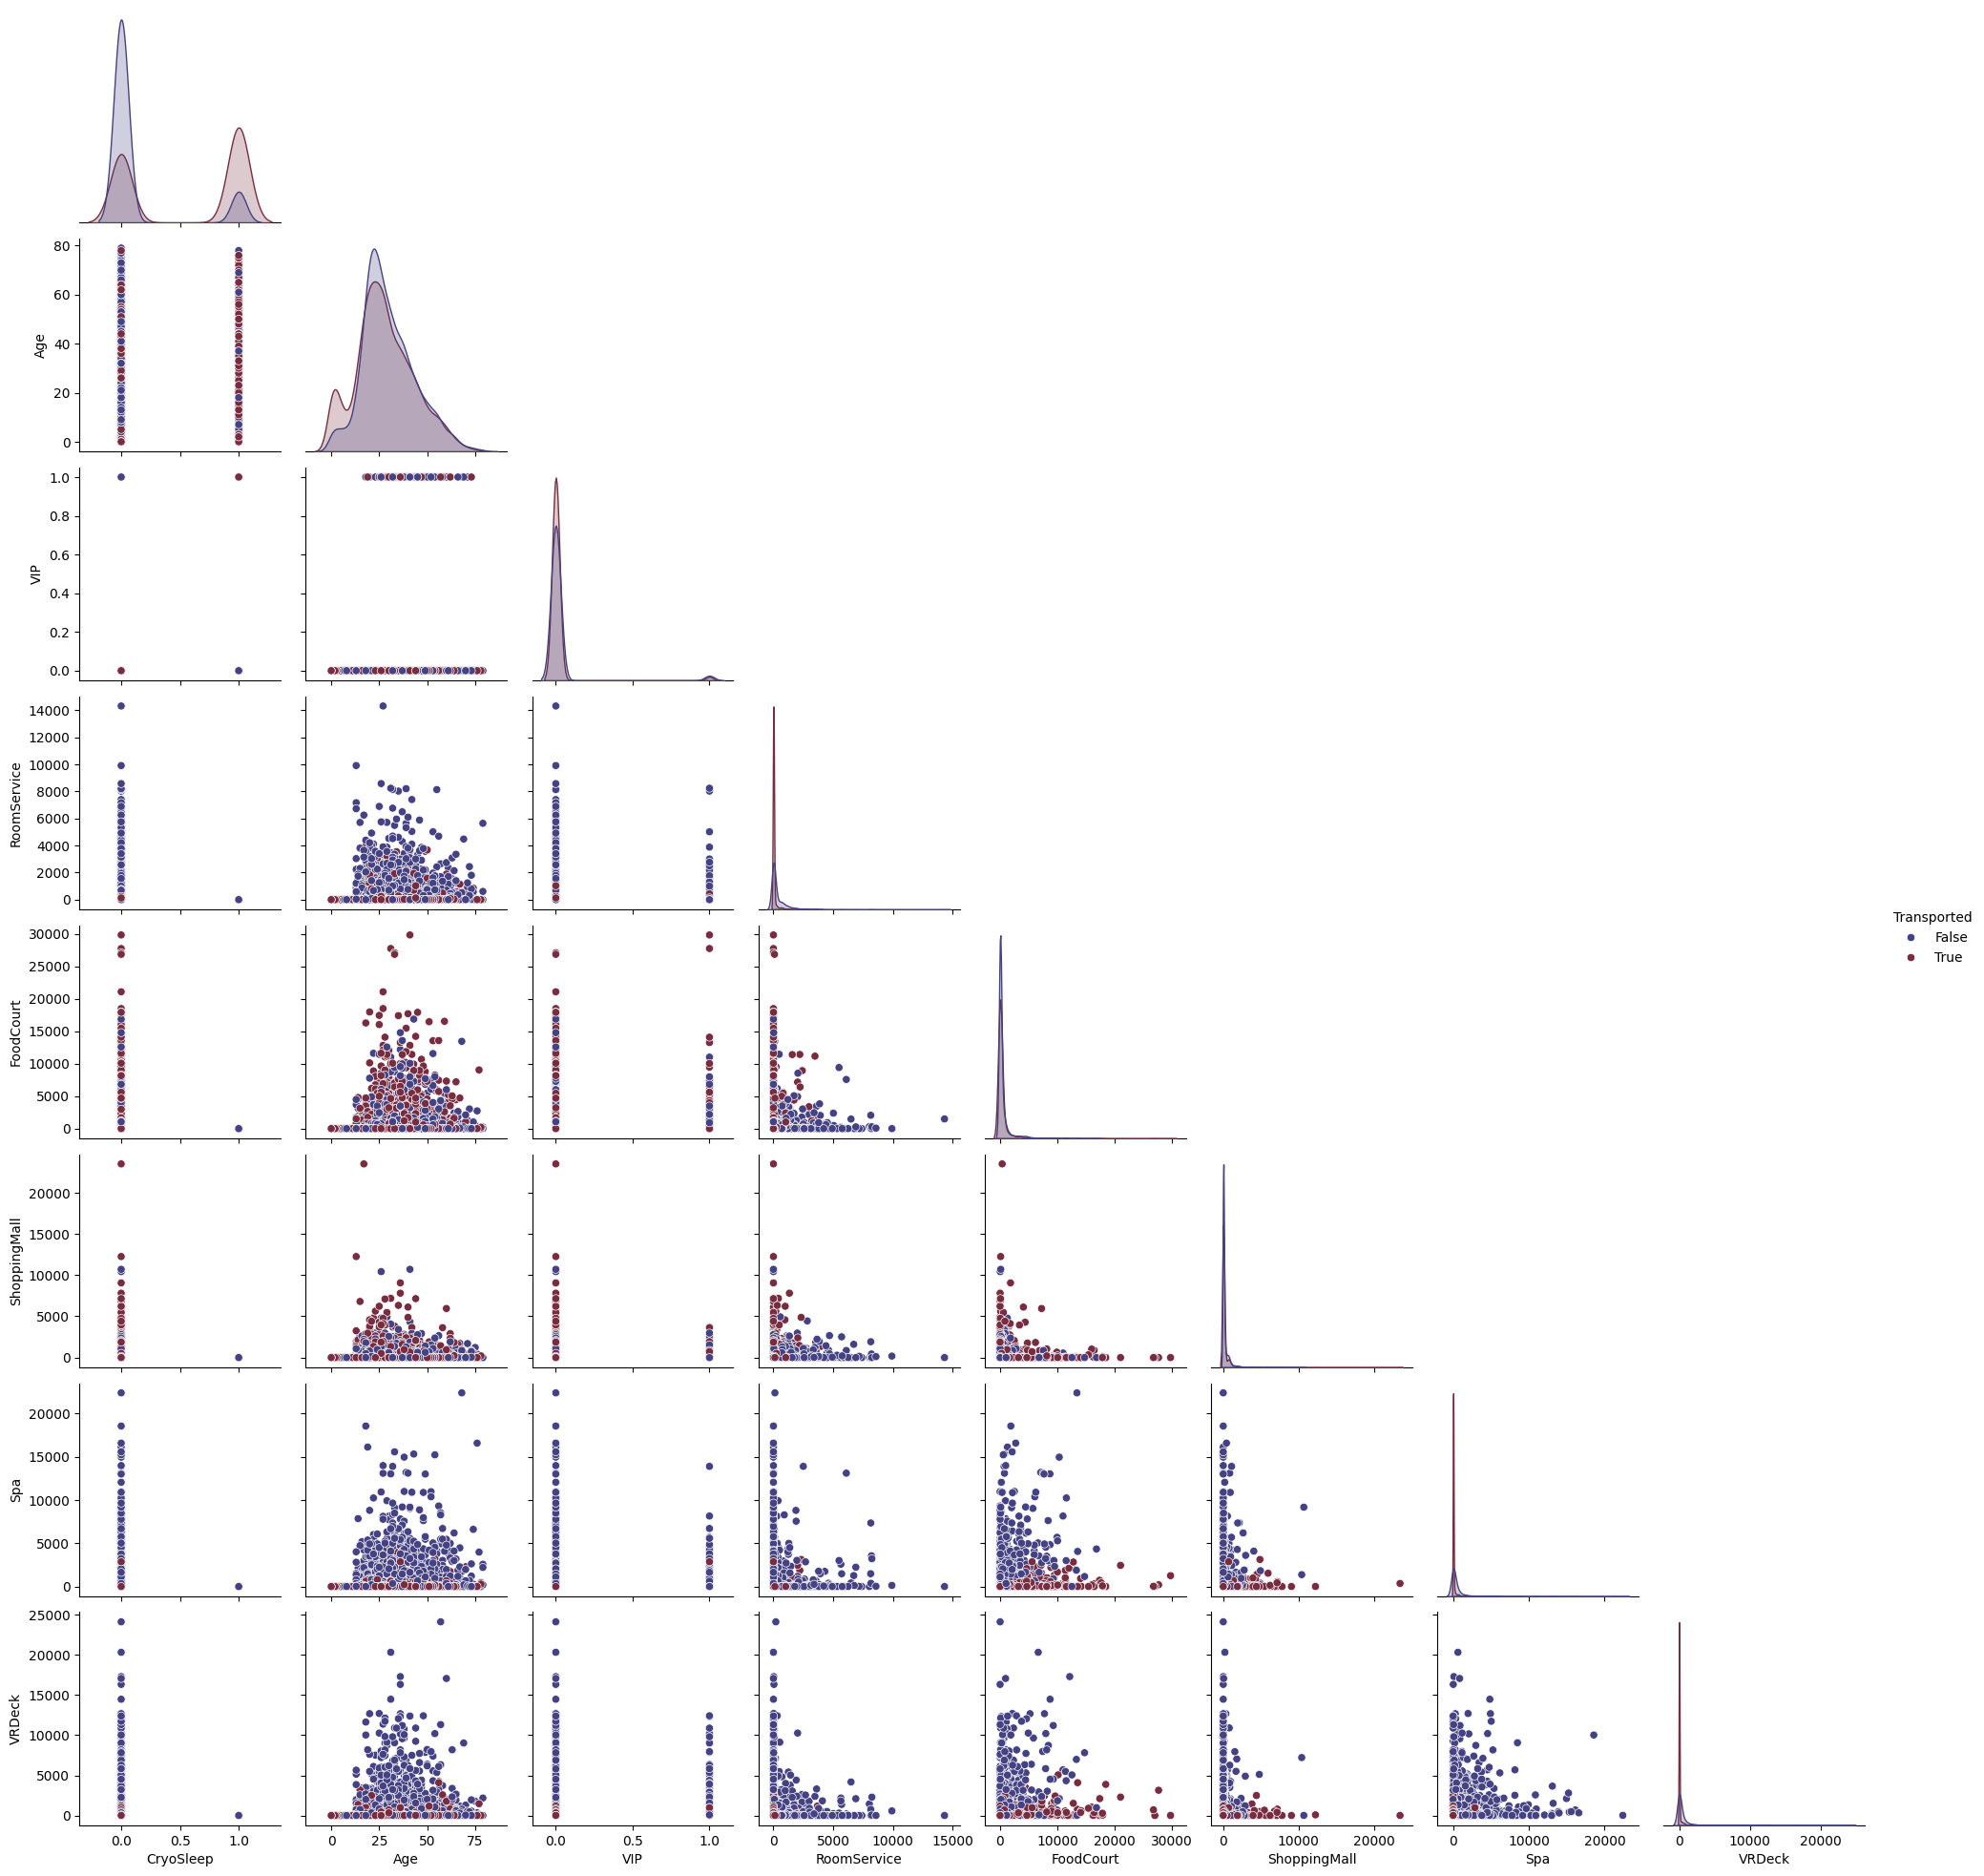

In [74]:
# overall fetures comparison
# just drop any empty values
sns.pairplot(data = df, dropna = True, hue='Transported', palette='icefire', corner=True)

Некоторые наблюдения из графиков выше:
* Б**о**льшая, часть из тех кто находился в криосне, были траспортированы в другое измерение (см. график Cryosleep-Cryosleep). Те кто *не* находились в криосне, в основном не были перемещены.
* График возраста показывает интересную зависимость – хотя общий срез транспортированных и не транспортированных пассажирова одинков, однако детей было явно больше транспортировано, относительо общего количества детей (левый хвост графиков Age-Age)
* Интересные завимости *SPA*/*VRDeck*-*FoodCourt*, те кто тратил больше денег на фуд-корте - попадали под число транспортированных. То же самое касается и *ShoppingMall*. Возможно это просто совпадение, или особенности отображения – надо будет проверить это численно.


Для получения числовой оценки, построим матрицу корреляций признаков. Нас будет интересовать корреляция с *Transported*.
Но при попытке ее построения, например так,
```
corr = df.corr()
sns.heatmap(corr, ...)
```
получим ошибку, потому что на текущий момент датафрейм содержит много категориальных значений, которые нужно для начала привести к численному представлению. Поэтому проведем первичную предобработку данных.

# Предобработка данных

Весь процессинг данных будем оформлять в виде функций. Так будет удобнее – позднее мы воспользуемся теми же функциями для обработки тестовых данных при подготовке решения к отправке.

Препроцессинг должен включать следующие операции (для каждого признака):
* Предобработка признаков (изменение типов данных)
* Заполнение пропусков в данных
* Кодирование признаков (бинарное, one-hot encoding)
* Нормирование/выравнивание/батчинг

Одним из самых важных тут является обработка пустых значений. Есть несколько стратегий при обработке пустых значений:
* убрать столбец из рассмотрения -> очень старая и очень плохая техника
* убрать строки, содержащие пустые значения -> также старая и плохая техника, сейчас применять их - плохой тон
* заполнить пустые значения агрегатами (средние, медианные и др. значения) - можно использовать, если других подходов нет
* спрогнозировать значения на базе известных – рекомендуемая к применению техника, но требует разработки отдельных мини-моделей для предсказания пропущенных значений, либо можно воспользоваться уже готовыми Impute() функциями
* экспертное заполнение – в идеале собрать пропущенные значения заново, если нет возможности, заполнить на базе экспертной информации

In [75]:
# Создание новых фичей для Spaceship Titanic
df['HasCabin'] = df['Cabin'].notnull().astype(int)
df['Group'] = df['PassengerId'].str.split('_').str[0]
df['TotalSpent'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
df['IsAlone'] = (df['Group'].map(df['Group'].value_counts()) == 1).astype(int)
df['Missing'] = df.isnull().sum(axis=1)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HasCabin,Group,TotalSpent,IsAlone,Missing
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,0001,0.0,1,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,0002,736.0,1,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,0003,10383.0,0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1,0003,5176.0,0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,0004,1091.0,1,0


In [76]:
def process_passenger_id(df):
    
    # помним, что формат идентификатора - gggg_pp
    #df[['gggg','pp']] = df['PassengerId'].str.split('_',expand=True)
    gggg_pp = df['PassengerId'].str.split('_',expand=True)   
    gggg_pp = gggg_pp.astype(int)
    
    # group gggg to get # of values -> group size
    # 0 index - первая колонка содержит "gggg"
    # 1 index - вторая колонка содержит "pp"
    # 2 index - будет содержать размер группы
    x = gggg_pp[0].value_counts()
    
    # создадим еще одну колонку, содержащую размер группы
    # используем .value_counts() чтобы обойтись без подзапросов с группировками
    gggg_pp[2] = gggg_pp[0].apply(lambda i: x[i])
    
    # сохраним новые колонки в датафрейм
    df[['PassengerGroup', 'PassengerNum', 'PassengerGroupSize']] = gggg_pp
    
    return df
    

In [77]:
# проверим результат
process_passenger_id(df).head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,HasCabin,Group,TotalSpent,IsAlone,Missing,PassengerGroup,PassengerNum,PassengerGroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,1,0001,0.0,1,0,1,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Juanna Vines,True,1,0002,736.0,1,0,2,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Altark Susent,False,1,0003,10383.0,0,0,3,1,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,Solam Susent,False,1,0003,5176.0,0,0,3,2,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,Willy Santantines,True,1,0004,1091.0,1,0,4,1,1


In [78]:
# сделаем признак, путешествует ли пассажир в одиночестве или нет
def is_travelling_alone(df):
    df.loc[df['PassengerGroupSize'] == 1, 'IsTravellingAlone'] = True
    df.loc[df['PassengerGroupSize'] != 1, 'IsTravellingAlone'] = False
    
    return df

In [79]:
# преобразуем форматы из строковых в булевые
def preproccess_cryosleep_vip(df):
    # здесь True и False - это строки, конвертируем их в булевое представление
    df['CryoSleep'] = df['CryoSleep'].astype("boolean")
    df['VIP'] = df['VIP'].astype("boolean")
    
    return df

In [80]:
df2 = process_passenger_id(df)
df2 = is_travelling_alone(df2)
df2 = preproccess_cryosleep_vip(df2)

In [81]:
df2.isnull().sum()

PassengerId             0
HomePlanet            201
CryoSleep             217
Cabin                 199
Destination           182
Age                   179
VIP                   203
RoomService           181
FoodCourt             183
ShoppingMall          208
Spa                   183
VRDeck                188
Name                  200
Transported             0
HasCabin                0
Group                   0
TotalSpent              0
IsAlone                 0
Missing                 0
PassengerGroup          0
PassengerNum            0
PassengerGroupSize      0
IsTravellingAlone       0
dtype: int64

In [82]:
# будем заполнять отправку и назначение по следующим правилами:
# если пассажир путешествует в группе - то отправка и назначения его группы
# если в одиночку и нет HomePlanet/Destination -> заполним наиболее частыми значениями по всему датасету

def fill_homeplanet_destination(df):
    homeplanet_modes_by_groupnum = df.groupby(['PassengerGroup'])['HomePlanet'].apply(pd.Series.mode)
    destination_modes_by_groupnum = df.groupby(['PassengerGroup'])['Destination'].apply(pd.Series.mode)
    
    def get_home(x):
        if (not x.HomePlanet) and (x.PassengerGroupSize > 1):
            return homeplanet_modes_by_groupnum[x.PassengerGroup][0]
        else:
            return x.HomePlanet
        
    def get_destination(x):
        if (not x.Destination) and (x.PassengerGroupSize > 1):
            return destination_modes_by_groupnum[x.PassengerGroup][0]
        else:
            return x.Destination
    
    df['HomePlanet'] = df.apply(lambda x: get_home(x), axis=1)
    df['Destination'] = df.apply(lambda x: get_destination(x), axis=1)
    
    return df
    
    

In [83]:
df2.loc[(df2['HomePlanet'].isnull()) & (df2['PassengerGroupSize']>1)].head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,HasCabin,Group,TotalSpent,IsAlone,Missing,PassengerGroup,PassengerNum,PassengerGroupSize,IsTravellingAlone
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,...,True,1,0064,0.0,0,2,64,2,2,False
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,...,False,1,0119,9307.0,0,1,119,1,2,False
405,0444_02,NaN,False,F/99/P,TRAPPIST-1e,26.0,True,1869.0,0.0,136.0,...,False,1,0444,2005.0,0,1,444,2,2,False
407,0445_02,NaN,False,E/25/S,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,...,False,1,0445,792.0,0,1,445,2,2,False
438,0470_02,NaN,True,F/86/S,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,...,True,1,0470,0.0,0,1,470,2,2,False


In [84]:
fill_homeplanet_destination(df2).head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,HasCabin,Group,TotalSpent,IsAlone,Missing,PassengerGroup,PassengerNum,PassengerGroupSize,IsTravellingAlone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,1,0001,0.0,1,0,1,1,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,1,0002,736.0,1,0,2,1,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,1,0003,10383.0,0,0,3,1,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,False,1,0003,5176.0,0,0,3,2,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,True,1,0004,1091.0,1,0,4,1,1,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,...,True,1,0005,774.0,1,0,5,1,1,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,...,True,1,0006,1584.0,0,0,6,1,2,False
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,...,True,1,0006,0.0,0,1,6,2,2,False
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,...,True,1,0007,1018.0,1,0,7,1,1,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,...,True,1,0008,0.0,0,0,8,1,3,False


In [85]:
df2.isnull().sum()

PassengerId             0
HomePlanet            201
CryoSleep             217
Cabin                 199
Destination           182
Age                   179
VIP                   203
RoomService           181
FoodCourt             183
ShoppingMall          208
Spa                   183
VRDeck                188
Name                  200
Transported             0
HasCabin                0
Group                   0
TotalSpent              0
IsAlone                 0
Missing                 0
PassengerGroup          0
PassengerNum            0
PassengerGroupSize      0
IsTravellingAlone       0
dtype: int64

In [86]:
# какие-то элементарные операции вынесем в эту функцию
def preprocess_basic(df):
    
    # здесь True и False - это строки, конвертируем их в булевое представление
    df['CryoSleep'] = df['CryoSleep'].astype("boolean")
    df['VIP'] = df['VIP'].astype("boolean")
    
    #  One-hot encoding для перечислимых значений
    df = pd.get_dummies(data=df, columns=['HomePlanet', 'Destination'])
    
    return df

Заметим, что пока мы никак не обрабатываем пустые значения. Мы обязательно вернемся к ним позднее. Сейчас же мы хотим сформировать матрицу корреляций, зафиксировать текущее состояние и идти дальше.

<Axes: >

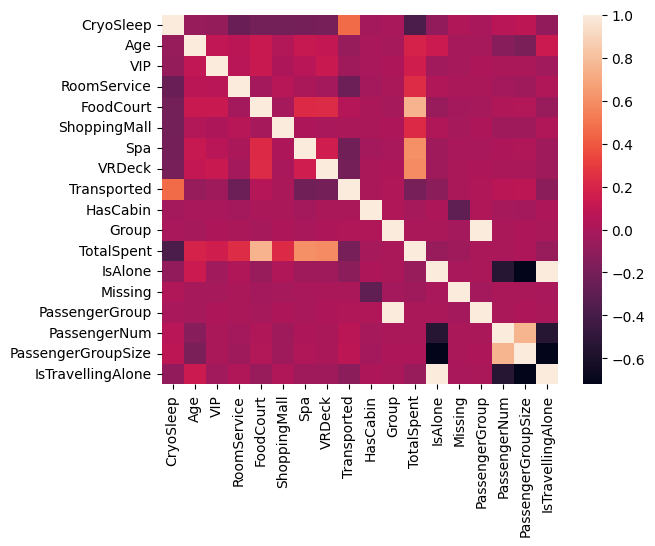

In [87]:
# уберем их только из представления для матрицы корреляции
not_needed_columns = ['PassengerId', 'Cabin', 'Name', 'HomePlanet', 'Destination']

corr = df.drop(columns=not_needed_columns).corr()
sns.heatmap(corr)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         8693 non-null   object 
 1   HomePlanet          8492 non-null   object 
 2   CryoSleep           8476 non-null   boolean
 3   Cabin               8494 non-null   object 
 4   Destination         8511 non-null   object 
 5   Age                 8514 non-null   float64
 6   VIP                 8490 non-null   boolean
 7   RoomService         8512 non-null   float64
 8   FoodCourt           8510 non-null   float64
 9   ShoppingMall        8485 non-null   float64
 10  Spa                 8510 non-null   float64
 11  VRDeck              8505 non-null   float64
 12  Name                8493 non-null   object 
 13  Transported         8693 non-null   bool   
 14  HasCabin            8693 non-null   int64  
 15  Group               8693 non-null   object 
 16  TotalS

## Feature importance by Logistic Regression

Применим несколько правил для заполнения пустых значений:
 - По-умолчанию принимаем 0.0 для всех незаданных трат (`RoomService`, `FoodCourt`, `Spa`, `ShoppingMall`, `VRDeck`)
 - Имена(`Name`) и каюты(`Cabin`) никак не заполняем
 - Отправления(`HomePlanet`)/Назначения(`Destination`) заполняем наиболее популярными значениями
 - `CryoSleep` устанавалием в `False`, если у пассажира есть траты (очевидно, что он не может тратить деньги, находясь в криосне), в противном случае = True
 - `Age` средним значение возраста
 - `VIP` наиболее частым значением (`False`)
 

In [89]:
def fill_na(df):
    
    df['CryoSleep'] = df['CryoSleep'].astype("boolean")
    
    # if no expenses => 0.0$
    df.loc[df['RoomService'].isnull(), 'RoomService'] = 0.0
    df.loc[df['FoodCourt'].isnull(), 'FoodCourt'] = 0.0
    df.loc[df['Spa'].isnull(), 'Spa'] = 0.0
    df.loc[df['ShoppingMall'].isnull(), 'ShoppingMall'] = 0.0
    df.loc[df['VRDeck'].isnull(), 'VRDeck'] = 0.0
    
    # if no Name specified => just empty string
    df.loc[df['Name'].isnull(), 'Name'] = ''
    df.loc[df['Cabin'].isnull(), 'Cabin'] = ''
    
    # HomePlanet & Destination let it be a most used
    df.loc[df['HomePlanet'].isnull(), 'HomePlanet'] = df['HomePlanet'].mode()[0]
    df.loc[df['Destination'].isnull(), 'Destination'] = df['Destination'].mode()[0]
    
    df.loc[(df['CryoSleep'].isnull()) & (df['RoomService'] + df['FoodCourt'] + df['Spa'] + df['ShoppingMall'] + df['VRDeck']) > 0, 'CryoSleep'] = False
    df.loc[df['CryoSleep'].isnull(), 'CryoSleep'] = True
    
    df.loc[df['Age'].isnull(), 'Age'] = df['Age'].mean()
        
    df.loc[df['VIP'].isnull(), 'VIP'] = df['VIP'].mode()[0]
    
    return df

In [90]:
def preprocess(df):
    
    df = df.drop(['Cabin', 'Name', 'PassengerId'], axis=1)
    
    df = pd.get_dummies(data=df, columns=['HomePlanet', 'Destination'])

#     le_homeplanet = LabelEncoder()
#     X['HomePlanet'] = le_homeplanet.fit_transform(X['HomePlanet'])

#     le_destination = LabelEncoder()
#     X['Destination'] = le_destination.fit_transform(X['Destination'])

    le_transported = LabelEncoder()
    df['Transported'] = le_transported.fit_transform(df['Transported'])
    
#     for c in df.columns:
#         sc = StandardScaler()
#         df[c] = sc.fit_transform(df[c])

    return df

In [91]:
from sklearn.pipeline import make_pipeline

def lr_pipeline():
    model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0))
    return model

def rf_pipeline():
    model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 0))
    return model

def catboost_pipeline():
    model = make_pipeline(StandardScaler(), CatBoostClassifier(random_state = 0))
    return model

In [92]:
def feature_importances(df):
        
    X = df.drop('Transported', axis=1)
    y = df[['Transported']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    
    # Logistic Regression    
    #clf_lr = LogisticRegression(random_state = 0)
    clf_lr = lr_pipeline()
    clf_lr.fit(X_train, y_train)
    #coef_lr = clf_lr.coef_[0]
    coef_lr = clf_lr[1].coef_[0]
    
    acc_train_lr = accuracy_score(y_true=y_train, y_pred=clf_lr.predict(X_train))
    acc_test_lr = accuracy_score(y_true=y_test, y_pred=clf_lr.predict(X_test))
    label_lr = f'Importance (LR abs), acc_train = {acc_train_lr:.2%}, acc_test = {acc_test_lr:.2%}'
    
    # Random Forest
    # clf_rf = RandomForestClassifier(random_state = 0)
    clf_rf = rf_pipeline()
    clf_rf.fit(X_train, y_train)
    #coef_rf = clf_rf.feature_importances_
    coef_rf = clf_rf[1].feature_importances_
    
    acc_train_rf = accuracy_score(y_true=y_train, y_pred=clf_rf.predict(X_train))
    acc_test_rf = accuracy_score(y_true=y_test, y_pred=clf_rf.predict(X_test))
    label_rf = f'Importance (LR abs), acc_train = {acc_train_rf:.2%}, acc_test = {acc_test_rf:.2%}'
    
    # CatBoost
    # clf_cat = CatBoostClassifier(random_state = 0)
    clf_cat = catboost_pipeline()
    clf_cat.fit(X_train, y_train, catboostclassifier__silent = True)
    #coef_cat = clf_cat.feature_importances_
    coef_cat = clf_cat[1].feature_importances_
    
    acc_train_cat = accuracy_score(y_true=y_train, y_pred=clf_cat.predict(X_train).astype('bool'))
    acc_test_cat = accuracy_score(y_true=y_test, y_pred=clf_cat.predict(X_test).astype('bool'))
    label_cat = f'Importance (LR abs), acc_train = {acc_train_cat:.2%}, acc_test = {acc_test_cat:.2%}'

    
    feauture_importances = pd.DataFrame({
        'Feature': X.columns,
        'LR': np.abs(coef_lr),
        'RF': coef_rf,
        'CatBoost': coef_cat
    })
    
    feauture_importances = feauture_importances.sort_values(by = 'CatBoost', ascending=False)
    
    sc = MaxAbsScaler()
    feauture_importances[['LR']] = sc.fit_transform(feauture_importances[['LR']])
    feauture_importances[['RF']] = sc.fit_transform(feauture_importances[['RF']])
    feauture_importances[['CatBoost']] = sc.fit_transform(feauture_importances[['CatBoost']])
    
    # Plot everything
    
    feauture_importances.plot(kind='barh', x='Feature')
    
#     ax = plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (LR abs)'], label = label_lr)
#     plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (RF)'], label = label_rf, axes=ax)
#     plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (Cat)'], label = label_cat, axes=ax)
#     plt.show()



    return ([acc_train_lr, acc_train_rf, acc_train_cat], [acc_test_lr, acc_test_rf, acc_test_cat])
    
    

In [93]:
df2 = fill_na(df)
df2 = preprocess(df2)


In [94]:
df2.isnull().sum()

CryoSleep                    0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
HasCabin                     0
Group                        0
TotalSpent                   0
IsAlone                      0
Missing                      0
PassengerGroup               0
PassengerNum                 0
PassengerGroupSize           0
IsTravellingAlone            0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
dtype: int64

/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ivan/IT/Nod/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_

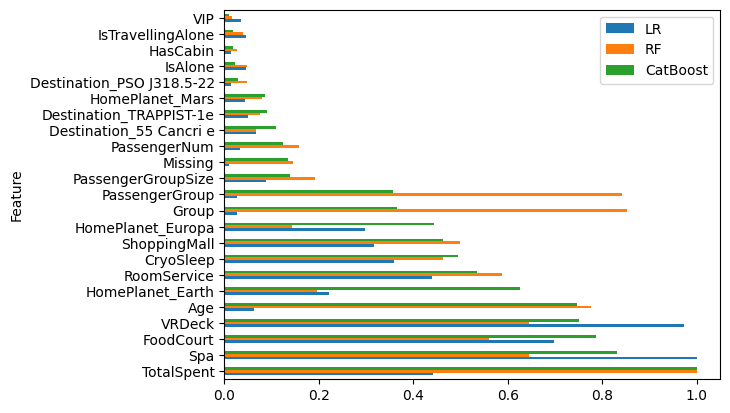

In [95]:
#'HomePlanet', 'Destination', 'Name', 
#df2 = df2.drop(['PassengerId'], axis=1)
import numpy as np
acc_train, acc_test = feature_importances(df2)

<Axes: >

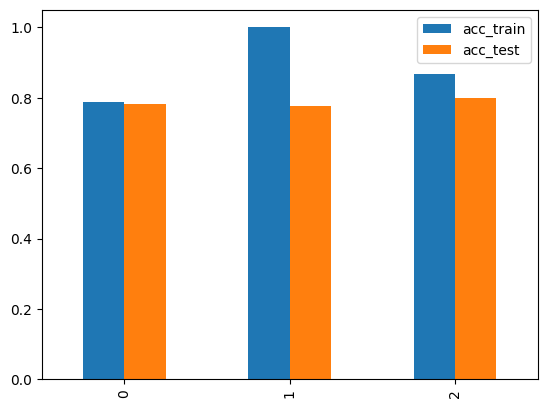

In [96]:
d = {
    'acc_train': acc_train,
    'acc_test': acc_test
}

acc_df = pd.DataFrame(d)
acc_df.plot.bar()

In [97]:
acc_df

,acc_train,acc_test
0,0.788311,0.783349
1,1.000000,0.777829
2,0.867771,0.798528


In [ ]:
#!pip install -U lightautoml

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 24.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 35.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 40.6 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 23.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.3 MB/s  0:00:00
   ━━━━

In [99]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [ ]:
#!pip3 install lightautoml

In [102]:
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
#from lightautoml.utils.profiler import Profiler

In [103]:
! python --version

Python 3.9.6


In [104]:
automl = TabularAutoML(
    task = Task(
        name = 'binary',
        metric = lambda y_true, y_pred: f1_score(y_true, (y_pred > 0.5)*1))
)

oof_pred = automl.fit_predict(
    df_train,
    roles = {'target': 'Transported', 'drop': ['PassengerId']}
)

AttributeError: `np.find_common_type` was removed in the NumPy 2.0 release. Use `numpy.promote_types` or `numpy.result_type` instead. To achieve semantics for the `scalar_types` argument, use `numpy.result_type` and pass the Python values `0`, `0.0`, or `0j`.